In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# for running in collab, sagemaker etc.
import sys
sys.path.insert(0, "/home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils")

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance
import pickle
import time
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error

import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
os.environ["CUDA_VISIBLE_DEVICES"]="1"

sns.set_theme()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load data

In [3]:
# proton
p_data = pd.read_pickle('../data/data_proton_photonsum_proton_15_2133_neutron_15_3273.pkl')
n_data = pd.read_pickle('../data/data_neutron_photonsum_proton_15_2133_neutron_15_3273.pkl')
c_data = pd.read_pickle('../data/data_proton_neutron_photonsum_proton_15_2133_neutron_15_3273_padding.pkl')

In [14]:
# neutron
print(print(n_data.shape), n_data.sum((1, 2)).min(), n_data.sum((1, 2)).max())

(48714, 44, 44)
None 15.0 3273.0


In [15]:
# proton
print(print(p_data.shape), p_data.sum((1, 2)).min(), p_data.sum((1, 2)).max())

(48714, 56, 30)
None 15.0 2133.0


In [19]:
# Joint
# Proton
print(print(c_data.shape), c_data[:,:,:,0].sum((1, 2)).min(), c_data[:,:,:,0].sum((1, 2)).max())
# Neutron
print(print(c_data.shape), c_data[:,:,:,1].sum((1, 2)).min(), c_data[:,:,:,1].sum((1, 2)).max())

(48714, 56, 44, 2)
None 15.0 2133.0
(48714, 56, 44, 2)
None 15.0 3273.0


In [ ]:
# neutron
print(n_data.shape), n_data.sum((1, 2)).min(), n_data.sum((1, 2)).max()

In [6]:
data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_15_2133_neutron_15_3273.pkl')

In [7]:
data_cond.shape, p_data.shape, n_data.shape, c_data.shape

((48714, 12), (48714, 56, 30), (48714, 44, 44), (48714, 56, 44, 2))

### Function for calculating sum of channels

In [20]:
from utils.utils import get_channel_masks, sum_channels_parallel

#### Get data info for plots

In [21]:
data_cond.drop(columns=['neutron_photon_sum', 'proton_photon_sum', 'Pdg'], inplace=True)

In [22]:
p_data = np.log(p_data+1)
p_data = np.float32(p_data)

n_data = np.log(n_data+1)
n_data = np.float32(n_data)

c_data = np.log(c_data+1)
c_data = np.float32(c_data)

In [23]:
p_x_train, p_x_test, p_y_train, p_y_test, = train_test_split(p_data, data_cond, test_size=0.2, shuffle=False, random_state=42)

p_scaler = StandardScaler()
p_y_train = p_scaler.fit_transform(p_y_train)
p_y_test = p_scaler.transform(p_y_test)

n_x_train, n_x_test, n_y_train, n_y_test, = train_test_split(n_data, data_cond, test_size=0.2, shuffle=False, random_state=42)

n_scaler = StandardScaler()
n_y_train = n_scaler.fit_transform(n_y_train)
n_y_test = n_scaler.transform(n_y_test)

c_x_train, c_x_test, c_y_train, c_y_test, = train_test_split(c_data, data_cond, test_size=0.2, shuffle=False, random_state=42)

c_scaler = StandardScaler()
c_y_train = c_scaler.fit_transform(c_y_train)
c_y_test = c_scaler.transform(c_y_test)

### Calculate channels for original simulation test data

In [24]:
p_org=np.exp(p_x_test)-1
p_ch_org = np.array(p_org).reshape(-1, 56, 30)
p_ch_org = pd.DataFrame(sum_channels_parallel(p_ch_org)).values

n_org=np.exp(n_x_test)-1
n_ch_org = np.array(n_org).reshape(-1, 44, 44)
n_ch_org = pd.DataFrame(sum_channels_parallel(n_ch_org)).values

c_org=np.exp(c_x_test)-1
c_ch_org = np.array(c_org).reshape(-1, 56, 44, )
c_ch_org = pd.DataFrame(sum_channels_parallel(c_ch_org)).values

In [25]:
p_org.shape, n_org.shape, c_org.shape

((9743, 56, 30), (9743, 44, 44), (9743, 56, 44, 2))

### Define functions for making histograms

In [26]:
def calculate_ws_ch(generator,
                    x_test, y_test,
                    ch_org, data_shape,
                    n_calc=5,
                    scale=1, noise_std=1):
    """
    Calculates ws distance for each channel separately.
    """
    ws = [0, 0, 0, 0, 0]
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1
        results = results * scale

        ch_gen = np.array(results).reshape(data_shape)
        ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
        for i in range(5):
            ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
        ws = np.array(ws)

    ws = ws / n_calc
    print("\n", "-" * 30, "\n")
    print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch" + str(n + 1), f'{score:.2f}', end=" ")

## Generate plots for all models

### Load models

In [27]:
sdigan_proton = tf.keras.models.load_model("C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\experiments\\sdi-gan_15_2133_08_05_2023_21_20\\models\\best_model\\gen_sdi_gan_62.h5", compile=False)
sdigan_neutron = tf.keras.models.load_model("C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\experiments\\gen_best_neutron_sdi_gan.h5", compile=False)
sdigan_proton_neutron_padded = tf.keras.models.load_model("C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\experiments\\sdi-gan-padded_20_1970_27_06_2023_22_32\\models\\gen_sdi-gan-padded_47.h5", compile=False)

### Calculate ws

In [28]:
# PROTON
calculate_ws_ch(sdigan_proton,
                p_x_test, p_y_test,
                p_ch_org, (-1, 56, 30))

305/305 [==============================] - 8s 26ms/step

 ------------------------------ 

ws mean 6.04 ch1 0.44 ch2 0.57 ch3 3.24 ch4 9.39 ch5 16.58 

In [29]:
# NEUTRON
calculate_ws_ch(sdigan_neutron,
                n_x_test, n_y_test,
                n_ch_org, (-1, 44, 44))

305/305 [==============================] - 2s 8ms/step

 ------------------------------ 

ws mean 75.66 ch1 98.45 ch2 85.60 ch3 6.71 ch4 7.03 ch5 180.50 

JOINT PROTON NEUTRON MODEL

In [30]:
# PROTON AND NEUTRON COMBINED WITH PADDING
calculate_ws_ch(sdigan_proton_neutron_padded,
                c_x_test, c_y_test,
                c_ch_org, (-1, 56, 44, ))

305/305 [==============================] - 10s 31ms/step

 ------------------------------ 

ws mean 8.00 ch1 6.85 ch2 5.06 ch3 8.81 ch4 7.71 ch5 11.57 

### Plot samples

In [203]:
def generate_and_save_images(test_input):
    # produce predictions
    predictions_sdigan_p = sdigan_proton(test_input, training=False)
    predictions_sdigan_n = sdigan_neutron(test_input, training=False)
    predictions_sdigan_c = sdigan_proton_neutron_padded(test_input, training=False)

    fig, axs = plt.subplots(4, 5, figsize=(14, 10))
    # fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, 20):
        if i < 5:
            # Neutron model
            title_model = "Neutron responses"
            row = 0
            x = predictions_sdigan_n[i % 5].numpy().reshape(44, 44)
        elif i >= 5 and i < 10:
            title_model = "Neutron responses from Joint model"
            # Neutron data from joint model
            row = 1
            x = predictions_sdigan_c[:,:,:,1][i % 5].numpy().reshape(56, 44)
        elif i >= 10 and i < 15:
            # Proton data from joint model
            title_model = "Proton responses from Joint model"
            row = 2
            x = predictions_sdigan_c[:,:,:,0][i % 5].numpy().reshape(56, 44)
        else:
            title_model = "Proton responses"
            # Proton model
            row = 3
            x = predictions_sdigan_p[i % 5].numpy().reshape(56, 30)

        axs[row, 2].set_title(title_model, fontsize=16)
        im = axs[row, i % 5].imshow(x, cmap='gnuplot')
        axs[row, i % 5].axis('off')
        im_in_row.append(im)

        # add colorbar to the last image, but scale is with respect to the all images in row
        if i % 5 == 4:
            fig.colorbar(im, ax=axs[i // 5, :])
            # fig.colorbar.set_ylim(0, 4)
            # axs[row].colorbar(predictions_per_row, ax=axs[i % 5])
            # predictions_per_row = []

    plt.savefig("20, 40, 22, 24, 39 _ 4.png", dpi=300)
    plt.show()

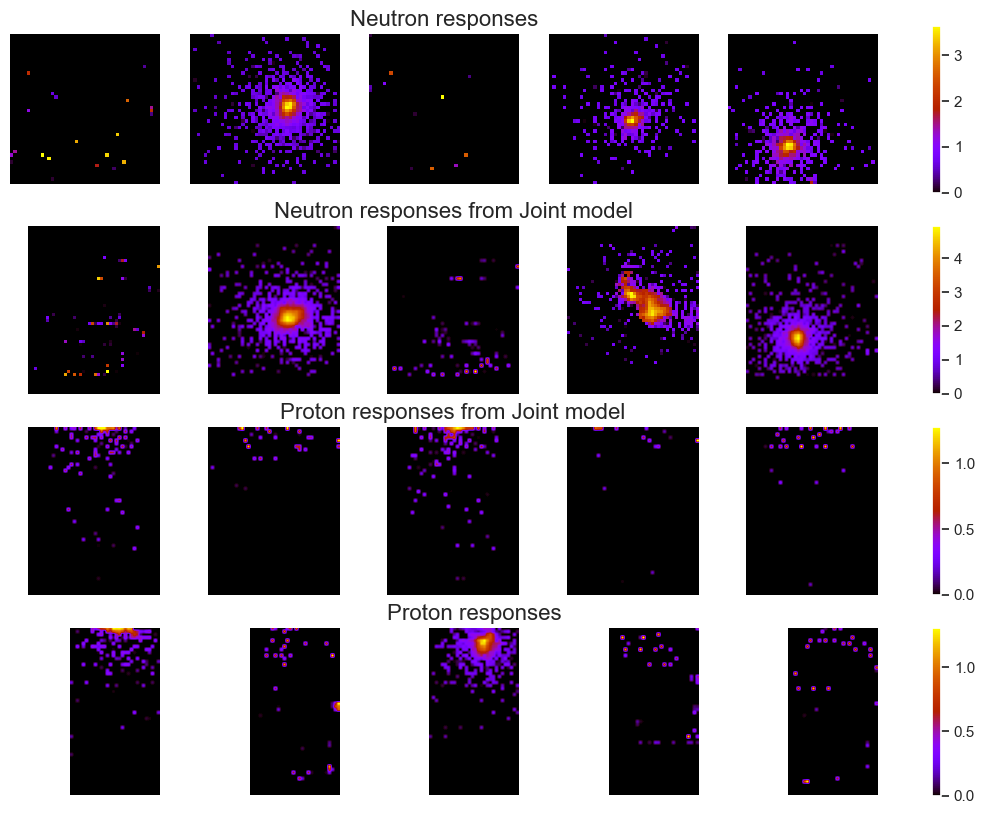

In [228]:
SAMPLES_IDXs = [20, 40, 22, 24, 39]
num_examples_to_generate = len(SAMPLES_IDXs)
noise_dim = 10

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = p_y_test[SAMPLES_IDXs]

generate_and_save_images([seed, seed_cond])

## Calculate time of generation

In [39]:
import timeit
N_OF_EXPERIMENTS_TO_GENERATE = 10

In [35]:
print("Number of samples for each experiment: {}".format(len(p_y_test)))

Number of samples for each experiment: 9743


In [36]:
from tabulate import tabulate

def plot_statistics(time_results):
    """
    Plots statistics of running execution time for experimets.
    :param time_resutls: List of execution time of each experiment.
    """
    stats_table = [
        ["Min: ", min(time_results)],
        ["Max: ", max(time_results)],
        ["Mean: ", np.mean(time_results)],
        ["Stddev: ", np.std(time_results)],
    ]
    table = tabulate(stats_table, tablefmt="github")
    table_title = "Execution time of experiment"
    full_table = f"{table_title}\n\n{table}"
    print(full_table)

#### Proton model

In [37]:
def generate_test_proton():
    num_examples_to_generate, noise_dim = len(p_y_test), 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdigan_proton.predict([seed, p_y_test])

In [232]:
execution_time_proton = timeit.repeat(generate_test_proton, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_proton)

305/305 [==============================] - 9s 29ms/step
Execution time of experiment

|---------|----------|
| Min:    | 7.96039  |
| Max:    | 9.34827  |
| Mean:   | 8.91293  |
| Stddev: | 0.424508 |


#### Neutron model

In [41]:
def generate_test_neutron():
    num_examples_to_generate, noise_dim = len(n_y_test), 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdigan_neutron.predict([seed, n_y_test])

In [234]:
execution_time_neutron = timeit.repeat(generate_test_neutron, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_neutron)

305/305 [==============================] - 2s 8ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 2.75746   |
| Max:    | 2.93267   |
| Mean:   | 2.82216   |
| Stddev: | 0.0502669 |


#### Joint Proton Neutron model

In [43]:
def generate_test_joint():
    num_examples_to_generate, noise_dim = len(c_y_test), 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdigan_proton_neutron_padded.predict([seed, c_y_test])

In [233]:
execution_time_c = timeit.repeat(generate_test_joint, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_c)

305/305 [==============================] - 9s 29ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 9.2675    |
| Max:    | 9.57876   |
| Mean:   | 9.39805   |
| Stddev: | 0.0954456 |
